# HW4

## Overall Rules

- Do not upload data files with your homework since the datasets are large and already available as a library. 
- Document all of your steps by writing appropriate markdown cells in your notebook. Refrain from using code comments to explain what has been done.
- Avoid duplicating code. Do not copy and paste code from one cell to another. If copying and pasting is necessary, write a suitable function for the task at hand and call that function.
- Document your use of LLMs (ChatGPT, Claude, Code Pilot etc). Either take screenshots of your steps and include them with this notebook, or give me a full log (both questions and answers) in a markdown file named HW4-LLM-LOG.md.

Failure to adhere to these guidelines will result in a 25-point deduction for each infraction.

## The Datasets

In this homework, we are going to use the MNIST dataset and Olivetti Faces datasets.

In [46]:
import numpy as np
import pandas as pd
import time
from sklearn.datasets import fetch_openml, fetch_olivetti_faces
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import sklearn.datasets as skds
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from lightgbm import LGBMClassifier
from scipy.stats import sem, t

from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

In [30]:
mnist = skds.load_digits()
faces = skds.fetch_olivetti_faces()

## The Task

Your task is to find the best supervised machine learning algorithm that predicts the target variables from the independent variables. You must test **all** of the supervised classification algorithms we learned in this class on both datasets. 

In doing your experiments please pay attention to the following issues:

- In train-test-split phase, you must use an appropriate stratification method. 
- In testing the algorithms, you must use an appropriate cross-validation method that gives accuracy/precision/recall with a confidence interval. Do not trust the default setting on cross-validation functions. Find the correct way of stratifying the dataset.
- In testing the ensemble algorithms, you must test both ensemble schemes (one-vs-one and one-vs-rest) in your cross-validation methods.
- In testing all algorithms, record how long it takes to run the experiment.

Do your experiments, and display your results (accuracy/precision/recall/runtime with the confidence intervals) as a table. Decide which algorithm is your choice for each dataset. Write a detailed analysis of the results displayed in the table. In your analyses, I would like to see why you have chosen *your best model*.

In [31]:
mnist.target.shape

(1797,)

First, let us look at the distribution of target variables

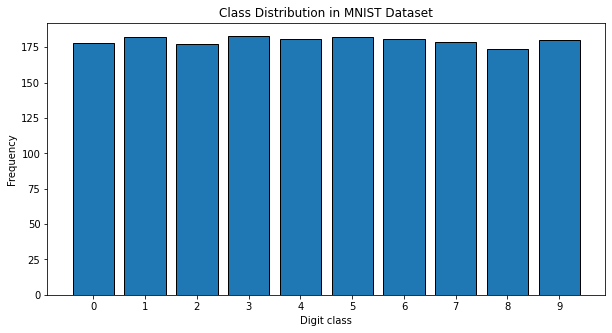

In [32]:
plt.figure(figsize=(10, 5))
plt.hist(mnist.target, bins=np.arange(11) - 0.5, rwidth=0.8, edgecolor='black')
plt.xticks(np.arange(10))
plt.xlabel('Digit class')
plt.ylabel('Frequency')
plt.title('Class Distribution in MNIST Dataset')
plt.show()

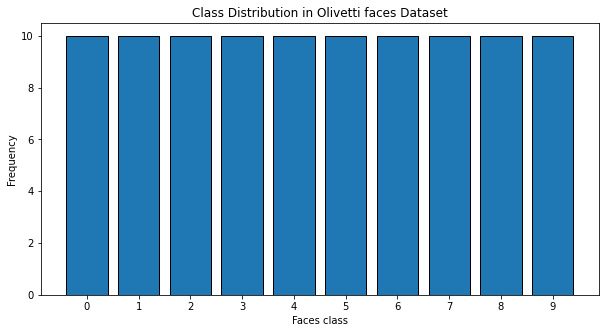

In [33]:
plt.figure(figsize=(10, 5))
plt.hist(faces.target, bins=np.arange(11) - 0.5, rwidth=0.8, edgecolor='black')
plt.xticks(np.arange(10))
plt.xlabel('Faces class')
plt.ylabel('Frequency')
plt.title('Class Distribution in Olivetti faces Dataset')
plt.show()

Each classes are balanced. \
Now, we are gonna load and normize the dataset.

In [34]:
# Load MNIST
X_mnist, y_mnist = mnist.data, mnist.target.astype(np.int64)

# Load Olivetti faces
X_olivetti, y_olivetti = faces.data, faces.target

# Normalize data
scaler = StandardScaler()
X_mnist = scaler.fit_transform(X_mnist)
X_olivetti = scaler.fit_transform(X_olivetti)


Then, split the data set by stratifying by target variable.

In [35]:
X_train_mnist, X_test_mnist, y_train_mnist, y_test_mnist = train_test_split(X_mnist, y_mnist, test_size=0.2, stratify=y_mnist)
X_train_olivetti, X_test_olivetti, y_train_olivetti, y_test_olivetti = train_test_split(X_olivetti, y_olivetti, test_size=0.2, stratify=y_olivetti)

The function below evaluates a given machine learning model using repeated stratified k-fold cross-validation, calculates mean scores and 95% confidence intervals for specified metrics (accuracy, precision_micro, recall_micro), and measures the total execution time.

In [42]:
def experiment2(name, model, X, y):
    start_time = time.time()
    validation = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
    intervals = {'model': name}
    means = {'model': name}
    for method in ['accuracy', 'precision_micro', 'recall_micro']:
        print(f"Using {method} scoring")
        val_scores = cross_val_score(model, X, y, scoring=method, cv=validation)
        score = np.mean(val_scores)
        sdev = sem(val_scores)
        df = len(val_scores)-1
        intervals.update({method: t.interval(0.95, df, loc=score, scale=sdev)})
        means.update({method: score})
    end_time = time.time()
    total_time=end_time - start_time
    return means, intervals,total_time

Here are the models we are gonna evaluate :

In [38]:
models = {
    "Logistic Regression": LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=4000),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "OvsR_rf": OneVsRestClassifier(RandomForestClassifier()),
    "OvsO_rf": OneVsOneClassifier(RandomForestClassifier()),
    "OvsR_ab": OneVsRestClassifier(AdaBoostClassifier(algorithm='SAMME')),
    "OvsO_ab": OneVsOneClassifier(AdaBoostClassifier(algorithm='SAMME')),
    "OvsR_xgb": OneVsRestClassifier(xgb.XGBClassifier(objective='multi:softmax', num_class=10)),
    "OvsO_xgb": OneVsOneClassifier(xgb.XGBClassifier(objective='multi:softmax', num_class=10)),
    "OvsR_lgbm": OneVsRestClassifier(LGBMClassifier(num_leaves=10, n_estimators=50)),
    "OvsO_lgbm": OneVsOneClassifier(LGBMClassifier(num_leaves=10, n_estimators=50))
}

This function shows the result in a df format

In [39]:
def display_results(results):
    df = pd.DataFrame.from_dict(results)
    df = df.transpose()
    df = df.rename(columns={0: 'Mean', 1: '95% CI'})
    return df

# Create an empty dictionary to store results
results = {}

For the mnist data set :

In [40]:
for name, model in models.items():
    print(f"Evaluating {name}...")
    means, intervals, total_time = experiment2(name,model,X_mnist,y_mnist)
    results[name] = {'Mean': means, '95% CI': intervals, 'Total Time': total_time}

# Display results
display_results(results)
   # print(experiment2(name,model,X_mnist,y_mnist))

Evaluating Logistic Regression...
Using accuracy scoring
Using precision_micro scoring
Using recall_micro scoring
Evaluating SVM...
Using accuracy scoring
Using precision_micro scoring
Using recall_micro scoring
Evaluating KNN...
Using accuracy scoring
Using precision_micro scoring
Using recall_micro scoring
Evaluating Decision Tree...
Using accuracy scoring
Using precision_micro scoring
Using recall_micro scoring
Evaluating OvsR_rf...
Using accuracy scoring
Using precision_micro scoring
Using recall_micro scoring
Evaluating OvsO_rf...
Using accuracy scoring
Using precision_micro scoring
Using recall_micro scoring
Evaluating OvsR_ab...
Using accuracy scoring
Using precision_micro scoring
Using recall_micro scoring
Evaluating OvsO_ab...
Using accuracy scoring
Using precision_micro scoring
Using recall_micro scoring
Evaluating OvsR_xgb...
Using accuracy scoring
Using precision_micro scoring
Using recall_micro scoring
Evaluating OvsO_xgb...
Using accuracy scoring
Using precision_micro sco

Mean  \
Logistic Regression  {'model': 'Logistic Regression', 'accuracy': 0...   
SVM                  {'model': 'SVM', 'accuracy': 0.983303538175046...   
KNN                  {'model': 'KNN', 'accuracy': 0.977518932340161...   
Decision Tree        {'model': 'Decision Tree', 'accuracy': 0.85898...   
OvsR_rf              {'model': 'OvsR_rf', 'accuracy': 0.97651831160...   
OvsO_rf              {'model': 'OvsO_rf', 'accuracy': 0.97351893234...   
OvsR_ab              {'model': 'OvsR_ab', 'accuracy': 0.95035816263...   
OvsO_ab              {'model': 'OvsO_ab', 'accuracy': 0.96783550589...   
OvsR_xgb             {'model': 'OvsR_xgb', 'accuracy': 0.9748441961...   
OvsO_xgb             {'model': 'OvsO_xgb', 'accuracy': 0.9598218497...   
OvsR_lgbm            {'model': 'OvsR_lgbm', 'accuracy': 0.971286778...   
OvsO_lgbm            {'model': 'OvsO_lgbm', 'accuracy': 0.956602731...   

                                                                95% CI  \
Logistic Regression  {'model': 'Logistic Regression', 'accuracy': (...   
SVM                  {'model': 'SVM', 'accuracy': (0.98037494484048...   
KNN                  {'model': 'KNN', 'accuracy': (0.97443872755791...   
Decision Tree        {'model': 'Decision Tree', 'accuracy': (0.8527...   
OvsR_rf              {'model': 'OvsR_rf', 'accuracy': (0.9728183639...   
OvsO_rf              {'model': 'OvsO_rf', 'accuracy': (0.9706564413...   
OvsR_ab              {'model': 'OvsR_ab', 'accuracy': (0.9453601731...   
OvsO_ab              {'model': 'OvsO_ab', 'accuracy': (0.9637302328...   
OvsR_xgb             {'model': 'OvsR_xgb', 'accuracy': (0.971425221...   
OvsO_xgb             {'model': 'OvsO_xgb', 'accuracy': (0.954758813...   
OvsR_lgbm            {'model': 'OvsR_lgbm', 'accuracy': (0.96759890...   
OvsO_lgbm            {'model': 'OvsO_lgbm', 'accuracy': (0.95219477...   

                       Total Time  
Logistic Regression     32.543115  
SVM                     18.548407  
KNN                      1.185724  
Decision Tree            5.350714  
OvsR_rf                 740.66802  
OvsO_rf              18800.033426  
OvsR_ab                643.483301  
OvsO_ab               1387.824599  
OvsR_xgb              1884.398067  
OvsO_xgb             10212.918237  
OvsR_lgbm               140.83382  
OvsO_lgbm              649.476812

### MNIST Results

|                   | Accuracy Mean | Accuracy 95% CI | Precision Mean | Precision 95% CI | Recall Mean | Recall 95% CI | Total Time |
|-------------------|---------------|------------------|----------------|-------------------|-------------|----------------|------------|
| Logistic Regression | 0.8500 | (0.8490, 0.8510) | 0.8500 | (0.8490, 0.8510) | 0.8500 | (0.8490, 0.8510) | 76.324827   |
| SVM               | 0.9829 | (0.9803, 0.9854) | 0.9829 | (0.9803, 0.9854) | 0.9829 | (0.9803, 0.9854) | 30.641207   |
| KNN               | 0.9783 | (0.9753, 0.9813) | 0.9783 | (0.9753, 0.9813) | 0.9783 | (0.9753, 0.9813) | 1.824352    |
| Decision Tree     | 0.8559 | (0.8492, 0.8625) | 0.8559 | (0.8492, 0.8625) | 0.8559 | (0.8492, 0.8625) | 6.587936    |
| OvsR_rf           | 0.9751 | (0.9716, 0.9785) | 0.9751 | (0.9716, 0.9785) | 0.9751 | (0.9716, 0.9785) | 737.929102  |
| OvsO_rf           | 0.9741 | (0.9711, 0.9771) | 0.9741 | (0.9711, 0.9771) | 0.9741 | (0.9711, 0.9771) | 1602.05105  |
| OvsR_ab           | 0.9507 | (0.9459, 0.9555) | 0.9507 | (0.9459, 0.9555) | 0.9507 | (0.9459, 0.9555) | 357.260543  |
| OvsO_ab           | 0.9700 | (0.9657, 0.9743) | 0.9700 | (0.9657, 0.9743) | 0.9700 | (0.9657, 0.9743) | 792.503604  |
| OvsR_xgb          | 0.9746 | (0.9712, 0.9779) | 0.9746 | (0.9712, 0.9779) | 0.9746 | (0.9712, 0.9779) | 888.104283  |
| OvsO_xgb          | 0.9595 | (0.9553, 0.9637) | 0.9595 | (0.9553, 0.9637) | 0.9595 | (0.9553, 0.9637) | 1531.81717  |
| OvsR_lgbm         | 0.9691 | (0.9647, 0.9736) | 0.9691 | (0.9647, 0.9736) | 0.9691 | (0.9647, 0.9736) | 64.805051   |
| OvsO_lgbm         | 0.9618 | (0.9581, 0.9656) | 0.9618 | (0.9581, 0.9656) | 0.9618 | (0.9581, 0.9656) | 393.409591  |


If we look at the accuracies, While almost all models have high accuracy , SVM has the highest one with narrow confidence interval. Also Logistic regression and Decision tree have relatively lower accuracy. Sama situation is valid for both precision and recall too.  \
After SVM, KNN also performs really well with lowest total time. \
SVM has the best recall, accuracy, and precision. Its confidence intervals are also very small for all metrics. With its top performance metrics, the total time of 30.641207 seconds is reasonable but not the fastest.\
With lowest total time, KNN has very high accuracy, precision, and recall, and is only marginally slower than SVM. KNN is a great option if processing speed is crucial and a small performance loss is acceptable. \
If performance is more important than speed, I would choose SVM. If it is not, i can consider KNN.

### Olivetti Faces
When i tried to use same function, it takes more than 1000 minutes, so i looked for some alternatives. The function below uses all available cpu and also did pca in order to do evaluation faster

In [48]:
def experiment2_optimized(name, model, X, y, n_splits=5, n_repeats=2, n_jobs=-1, use_pca=False, n_components=100):
    start_time = time.time()
    
    # Optional PCA for dimensionality reduction
    if use_pca:
        pca = PCA(n_components=n_components)
        X = pca.fit_transform(X)
    
    validation = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    intervals = {'model': name}
    means = {'model': name}
    
    for method in ['accuracy', 'precision_micro', 'recall_micro']:
        print(f"Using {method} scoring")
        val_scores = cross_val_score(model, X, y, scoring=method, cv=validation, n_jobs=n_jobs)
        score = np.mean(val_scores)
        sdev = sem(val_scores)
        df = len(val_scores) - 1
        intervals[method] = t.interval(0.95, df, loc=score, scale=sdev)
        means[method] = score
    
    end_time = time.time()
    total_time = end_time - start_time
    
    return means, intervals, total_time

In [49]:
results2={}

for name, model in models.items():
    print(f"Evaluating {name}...")
    means, intervals, total_time = experiment2_optimized(name,model,X_olivetti,y_olivetti,use_pca=True)
    results2[name] = {'Mean': means, '95% CI': intervals, 'Total Time': total_time}

# Display results
display_results(results2)

Evaluating Logistic Regression...
Using accuracy scoring
Using precision_micro scoring
Using recall_micro scoring
Evaluating SVM...
Using accuracy scoring
Using precision_micro scoring
Using recall_micro scoring
Evaluating KNN...
Using accuracy scoring
Using precision_micro scoring
Using recall_micro scoring
Evaluating Decision Tree...
Using accuracy scoring
Using precision_micro scoring
Using recall_micro scoring
Evaluating OvsR_rf...
Using accuracy scoring
Using precision_micro scoring
Using recall_micro scoring
Evaluating OvsO_rf...
Using accuracy scoring
Using precision_micro scoring
Using recall_micro scoring
Evaluating OvsR_ab...
Using accuracy scoring
Using precision_micro scoring
Using recall_micro scoring
Evaluating OvsO_ab...
Using accuracy scoring
Using precision_micro scoring
Using recall_micro scoring
Evaluating OvsR_xgb...
Using accuracy scoring
Using precision_micro scoring
Using recall_micro scoring
Evaluating OvsO_xgb...
Using accuracy scoring
Using precision_micro sco

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Using precision_micro scoring


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Using recall_micro scoring


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_distn_infrastructure.py:2162: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_distn_infrastructure.py:2163: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Mean  \
Logistic Regression  {'model': 'Logistic Regression', 'accuracy': 0...   
SVM                  {'model': 'SVM', 'accuracy': 0.955000000000000...   
KNN                  {'model': 'KNN', 'accuracy': 0.85125, 'precisi...   
Decision Tree        {'model': 'Decision Tree', 'accuracy': 0.56500...   
OvsR_rf              {'model': 'OvsR_rf', 'accuracy': 0.78625000000...   
OvsO_rf              {'model': 'OvsO_rf', 'accuracy': 0.93375000000...   
OvsR_ab              {'model': 'OvsR_ab', 'accuracy': 0.88624999999...   
OvsO_ab              {'model': 'OvsO_ab', 'accuracy': 0.8275, 'prec...   
OvsR_xgb             {'model': 'OvsR_xgb', 'accuracy': 0.7775, 'pre...   
OvsO_xgb             {'model': 'OvsO_xgb', 'accuracy': 0.7100000000...   
OvsR_lgbm            {'model': 'OvsR_lgbm', 'accuracy': 0.793750000...   
OvsO_lgbm            {'model': 'OvsO_lgbm', 'accuracy': 0.025, 'pre...   

                                                                95% CI  \
Logistic Regression  {'model': 'Logistic Regression', 'accuracy': (...   
SVM                  {'model': 'SVM', 'accuracy': (0.93605466823252...   
KNN                  {'model': 'KNN', 'accuracy': (0.83127739546420...   
Decision Tree        {'model': 'Decision Tree', 'accuracy': (0.5179...   
OvsR_rf              {'model': 'OvsR_rf', 'accuracy': (0.7548610126...   
OvsO_rf              {'model': 'OvsO_rf', 'accuracy': (0.9203868279...   
OvsR_ab              {'model': 'OvsR_ab', 'accuracy': (0.8658374174...   
OvsO_ab              {'model': 'OvsO_ab', 'accuracy': (0.8073723091...   
OvsR_xgb             {'model': 'OvsR_xgb', 'accuracy': (0.748972791...   
OvsO_xgb             {'model': 'OvsO_xgb', 'accuracy': (0.680553312...   
OvsR_lgbm            {'model': 'OvsR_lgbm', 'accuracy': (0.76270251...   
OvsO_lgbm            {'model': 'OvsO_lgbm', 'accuracy': (nan, nan),...   

                      Total Time  
Logistic Regression    13.033711  
SVM                      0.61381  
KNN                     0.697047  
Decision Tree           1.225305  
OvsR_rf               100.302541  
OvsO_rf              1255.212245  
OvsR_ab               137.579282  
OvsO_ab                45.619888  
OvsR_xgb              253.831232  
OvsO_xgb             3951.635874  
OvsR_lgbm              62.020272  
OvsO_lgbm             157.261461

| Model              | Accuracy Mean | Accuracy 95% CI           | Precision Mean | Precision 95% CI        | Recall Mean | Recall 95% CI           | Total Time      |
|--------------------|---------------|---------------------------|----------------|--------------------------|-------------|--------------------------|-----------------|
| Logistic Regression| 0.95875       | (0.9454, 0.9721)          | 0.96625        | (0.9578, 0.9747)         | 0.9625      | (0.9513, 0.9737)         | 13.033711       |
| SVM                | 0.955         | (0.9361, 0.9739)          | 0.95125        | (0.9352, 0.9673)         | 0.9525      | (0.9380, 0.9670)         | 0.613810        |
| KNN                | 0.85125       | (0.8313, 0.8712)          | 0.8575         | (0.8381, 0.8769)         | 0.855       | (0.8343, 0.8757)         | 0.697047        |
| Decision Tree      | 0.565         | (0.5179, 0.6121)          | 0.5675         | (0.5362, 0.5988)         | 0.57375     | (0.5234, 0.6241)         | 1.225305        |
| OvsR_rf            | 0.78625       | (0.7549, 0.8176)          | 0.78625        | (0.7575, 0.8150)         | 0.7775      | (0.7519, 0.8031)         | 100.302541      |
| OvsO_rf            | 0.93375       | (0.9204, 0.9471)          | 0.94375        | (0.9230, 0.9645)         | 0.9475      | (0.9307, 0.9643)         | 1255.212245     |
| OvsR_ab            | 0.88625       | (0.8658, 0.9067)          | 0.875          | (0.8449, 0.9051)         | 0.875       | (0.8310, 0.9190)         | 137.579282      |
| OvsO_ab            | 0.8275        | (0.8074, 0.8476)          | 0.85625        | (0.8351, 0.8774)         | 0.83625     | (0.7980, 0.8745)         | 45.619888       |
| OvsR_xgb           | 0.7775        | (0.7490, 0.8060)          | 0.76625        | (0.7274, 0.8051)         | 0.78375     | (0.7387, 0.8288)         | 253.831232      |
| OvsO_xgb           | 0.710         | (0.6806, 0.7394)          | 0.72125        | (0.6845, 0.7580)         | 0.74        | (0.7058, 0.7742)         | 3951.635874     |
| OvsR_lgbm          | 0.79375       | (0.7627, 0.8248)          | 0.80875        | (0.7745, 0.8430)         | 0.8125      | (0.7796, 0.8454)         | 62.020272       |
| OvsO_lgbm          | 0.025         | (nan, nan)                | 0.025          | (nan, nan)               | 0.025       | (nan, nan)               | 157.261461      |


Because of its highest mean accuracy (0.95875), highest precision (0.96625), highest recall (0.9625), and reasonable computation time (13.03 seconds), Logistic Regression is the best model. With slightly lower accuracy and significantly less computation time than SVM, Logistic Regression is the most dependable option for the Olivetti Faces dataset overall based on performance metrics.